### Dataset Structure

The dataset is already in YOLOv11 format and includes:

* train, valid, and test folders
* Each with images/ and labels/ subfolders
* A data.yaml file with class name and path definitions
* Class count: 1 (needle)

In [1]:
!pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Needle_detection/

/content/drive/MyDrive/Needle_detection


In [4]:
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load YOLOv11m (pretrained on COCO)
model = YOLO('yolo11m.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Exploratory Data Analysis (EDA)

Before training our object detection model, we want to:
- Understand how many images are in each dataset split
- Check if any label files are empty
- Visualize a sample with a bounding boxes
- Look at image sizes to confirm consistency

This helps us ensure data quality and avoid training problems later.

I removed 3 empty label files and their corresponding images from train/valid folders.
This ensures the model trains only on valid examples.

The data cleaning step is **repeatable and safe** to rerun as part of the notebook pipeline. It’s designed so that even if the dataset is already clean, it will make no changes.




In [35]:
train_labels = os.listdir('train/labels')
empty_labels = [lbl for lbl in train_labels if os.path.getsize(f"train/labels/{lbl}") == 0]

print(f"Total training labels: {len(train_labels)}")
print(f"Empty training labels: {len(empty_labels)}")

val_labels = os.listdir('valid/labels')
print(f"Total validation labels: {len(val_labels)}")
print(f"Empty validation labels: {sum(os.path.getsize(f'valid/labels/{l}') == 0 for l in val_labels)}")


Total training labels: 314
Empty training labels: 2
Total validation labels: 90
Empty validation labels: 1


In [36]:
total_boxes = 0

for label_file in train_labels:
    with open(f'train/labels/{label_file}', 'r') as f:
        lines = f.readlines()
        total_boxes += len(lines)

print(f"Total bounding boxes in training set: {total_boxes}")


Total bounding boxes in training set: 312


In [38]:
def remove_empty_labels(image_folder, label_folder):
    removed = 0
    for label_file in os.listdir(label_folder):
        label_path = os.path.join(label_folder, label_file)

        if os.path.getsize(label_path) == 0:  # If file is empty
            os.remove(label_path)
            image_name = label_file.replace(".txt", ".jpg")  # or .png
            image_path = os.path.join(image_folder, image_name)
            if os.path.exists(image_path):
                os.remove(image_path)
            removed += 1

    print(f"Removed {removed} empty label files and corresponding images.")

# Apply to train and val sets
remove_empty_labels("train/images", "train/labels")
remove_empty_labels("valid/images", "valid/labels")

Removed 2 empty label files and corresponding images.
Removed 1 empty label files and corresponding images.


In [9]:
import os

train_images = len(os.listdir('train/images'))
val_images   = len(os.listdir('valid/images'))
test_images  = len(os.listdir('test/images'))

print(f"Train images: {train_images}")
print(f"Validation images: {val_images}")
print(f"Test images: {test_images}")


Train images: 312
Validation images: 89
Test images: 43


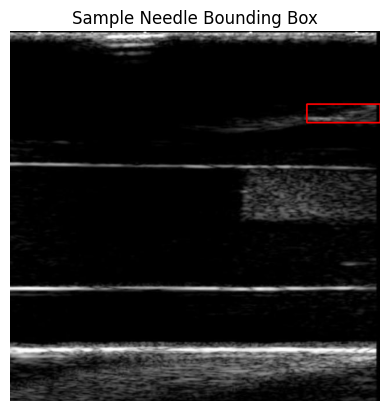

In [11]:
import cv2
import matplotlib.pyplot as plt

# Show one annotated image from train set
image_file = os.listdir('train/images')[0]
label_file = image_file.replace('.jpg', '.txt').replace('.jpeg', '.txt')  # adjust for extension

# Load image
img = cv2.imread(f'train/images/{image_file}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

# Draw boxes
with open(f'train/labels/{label_file}', 'r') as f:
    for line in f.readlines():
        cls, x_center, y_center, box_w, box_h = map(float, line.strip().split())
        # Convert YOLO to pixel coords
        x1 = int((x_center - box_w/2) * w)
        y1 = int((y_center - box_h/2) * h)
        x2 = int((x_center + box_w/2) * w)
        y2 = int((y_center + box_h/2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(img)
plt.title("Sample Needle Bounding Box")
plt.axis('off')
plt.show()


In [12]:
!ls train/labels | wc -l  # Label files left after deletion
!ls train/images | wc -l  # Image files left after deletion

312
312


### YOLOv11 Model Setup

We're using the yolov11m.pt pretrained weights.
This gives the model a strong starting point from general object detection knowledge (COCO dataset), allowing it to adapt quickly to our medical use case (needle detection).

Model was loaded and trained using:

50 epochs

Batch size = 8

Early Stopping = 10

In [13]:

model.train(
    data="data.yaml",
    epochs=50,                 # Keep it relatively small due to small dataset
    imgsz=640,                 # Resize for consistency
    batch=8,                   # Smaller batch due to small dataset
    patience=10,               # For early stopping
    name="needle_yolov11m",
    device=0
)

Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=needle_yolov11m, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1   1642496  ultralytics.nn.modules.block.C3k2            [1024, 512, 1, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    542720  ultralytics.nn.modules.block.C3k2            [1024, 256, 1, True]          
 17                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  1   1511424  ultralytics.nn.modules.block.C3k2            [768,

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.5 ms, read: 0.1±0.0 MB/s, size: 20.2 KB)


train: Scanning /content/drive/MyDrive/Needle_detection/train/labels... 312 images, 0 backgrounds, 0 corrupt: 100%|██████████| 312/312 [01:40<00:00,  3.11it/s]

train: New cache created: /content/drive/MyDrive/Needle_detection/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 0.1±0.0 MB/s, size: 24.0 KB)


val: Scanning /content/drive/MyDrive/Needle_detection/valid/labels... 89 images, 0 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:57<00:00,  1.54it/s]

val: New cache created: /content/drive/MyDrive/Needle_detection/valid/labels.cache


Plotting labels to runs/detect/needle_yolov11m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/needle_yolov11m
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.19G      2.072      3.481      2.041         12        640: 100%|██████████| 39/39 [00:21<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]

                   all         89         89     0.0178      0.169     0.0102    0.00382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.01G      2.023      2.968       2.06         19        640: 100%|██████████| 39/39 [00:12<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]

                   all         89         89          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.08G      2.089      2.728      2.149         17        640: 100%|██████████| 39/39 [00:13<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]

                   all         89         89          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.15G      1.934      2.312      1.971         18        640: 100%|██████████| 39/39 [00:13<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

                   all         89         89   0.000529      0.157   0.000333   9.72e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.21G      1.845       2.13      1.888         15        640: 100%|██████████| 39/39 [00:13<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.16it/s]


                   all         89         89      0.287      0.157      0.103      0.056

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.55G      1.706      1.947      1.782         14        640: 100%|██████████| 39/39 [00:13<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


                   all         89         89      0.523      0.461      0.448      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.62G      1.614      1.866       1.76         14        640: 100%|██████████| 39/39 [00:14<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]

                   all         89         89      0.503      0.433      0.454      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.68G      1.554      1.768      1.686          8        640: 100%|██████████| 39/39 [00:13<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]

                   all         89         89      0.765      0.366       0.46      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.75G      1.427      1.602       1.56         18        640: 100%|██████████| 39/39 [00:13<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]


                   all         89         89       0.34      0.539      0.388      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.81G      1.406      1.538       1.56         10        640: 100%|██████████| 39/39 [00:14<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.63it/s]

                   all         89         89      0.836      0.551      0.688      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.88G      1.368       1.45      1.501         14        640: 100%|██████████| 39/39 [00:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]

                   all         89         89      0.428       0.27      0.309      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.95G      1.306       1.38      1.497         15        640: 100%|██████████| 39/39 [00:13<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all         89         89      0.796      0.562      0.736      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.02G      1.323      1.363      1.515         15        640: 100%|██████████| 39/39 [00:13<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

                   all         89         89      0.612      0.697       0.71      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.08G      1.233      1.252      1.388         16        640: 100%|██████████| 39/39 [00:14<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

                   all         89         89      0.858      0.542      0.697      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.15G      1.245      1.277      1.404         14        640: 100%|██████████| 39/39 [00:15<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all         89         89      0.851      0.787       0.87      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.21G      1.236      1.227      1.382         19        640: 100%|██████████| 39/39 [00:14<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all         89         89      0.866      0.663      0.778      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.28G      1.162      1.148      1.343         16        640: 100%|██████████| 39/39 [00:13<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

                   all         89         89      0.945      0.773      0.892      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.35G      1.114      1.132      1.327         14        640: 100%|██████████| 39/39 [00:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]

                   all         89         89      0.909      0.786      0.893       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.41G      1.146      1.152      1.332         14        640: 100%|██████████| 39/39 [00:14<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

                   all         89         89      0.838      0.764      0.872      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.48G      1.093      1.068      1.287         15        640: 100%|██████████| 39/39 [00:13<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]

                   all         89         89      0.838      0.699      0.827      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.54G      1.068      1.007      1.263         11        640: 100%|██████████| 39/39 [00:13<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.53it/s]

                   all         89         89       0.85      0.753      0.888      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.61G      1.044     0.9941       1.25         12        640: 100%|██████████| 39/39 [00:13<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

                   all         89         89       0.95       0.86      0.927      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.68G       1.03     0.9807      1.252         12        640: 100%|██████████| 39/39 [00:14<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

                   all         89         89      0.817      0.719      0.796      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.74G       1.06       1.05      1.288         11        640: 100%|██████████| 39/39 [00:12<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]

                   all         89         89      0.996      0.876       0.94      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.81G      1.009     0.9694      1.235         18        640: 100%|██████████| 39/39 [00:13<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all         89         89      0.846      0.867      0.933      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.91G     0.9947     0.9401      1.229         21        640: 100%|██████████| 39/39 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all         89         89      0.958      0.865      0.936      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       7.3G     0.9594     0.8875      1.212         20        640: 100%|██████████| 39/39 [00:14<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]

                   all         89         89      0.867      0.719      0.836      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.37G     0.9545     0.9016      1.219         14        640: 100%|██████████| 39/39 [00:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

                   all         89         89      0.939      0.843      0.926      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.73G     0.9207     0.8632      1.191         17        640: 100%|██████████| 39/39 [00:15<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]

                   all         89         89      0.912      0.831      0.923      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.27G     0.9306     0.8603      1.185         16        640: 100%|██████████| 39/39 [00:14<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all         89         89      0.889      0.904      0.934      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.27G     0.9395     0.8731      1.223         15        640: 100%|██████████| 39/39 [00:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all         89         89      0.772      0.955      0.938      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.27G     0.9273     0.8277       1.18          9        640: 100%|██████████| 39/39 [00:13<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]

                   all         89         89      0.899      0.899      0.955      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.27G     0.8628     0.7867       1.14         23        640: 100%|██████████| 39/39 [00:14<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]

                   all         89         89      0.855      0.926      0.953      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.27G      0.884     0.8071      1.145         15        640: 100%|██████████| 39/39 [00:13<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

                   all         89         89       0.88      0.907      0.928      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.27G     0.8417      0.789      1.136         13        640: 100%|██████████| 39/39 [00:16<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]

                   all         89         89      0.988      0.929      0.961      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.33G     0.8211     0.7267      1.119         16        640: 100%|██████████| 39/39 [00:14<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

                   all         89         89      0.971      0.921      0.961      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       5.4G     0.8051     0.6817      1.094         11        640: 100%|██████████| 39/39 [00:14<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.53it/s]

                   all         89         89      0.867      0.953      0.957      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.79G     0.8201     0.7529       1.12         18        640: 100%|██████████| 39/39 [00:15<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]

                   all         89         89      0.943      0.936      0.965      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.85G     0.7957     0.6983      1.118         12        640: 100%|██████████| 39/39 [00:14<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]

                   all         89         89      0.949      0.933      0.963      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.92G     0.7884     0.7058      1.108         18        640: 100%|██████████| 39/39 [00:14<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]

                   all         89         89      0.976      0.918      0.967      0.797


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.98G     0.6688     0.5457       1.03          8        640: 100%|██████████| 39/39 [00:15<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all         89         89      0.988      0.906      0.965      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.05G     0.6704     0.5331      1.058          8        640: 100%|██████████| 39/39 [00:12<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all         89         89      0.955      0.955       0.97      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.12G     0.6414     0.4944      1.034          8        640: 100%|██████████| 39/39 [00:14<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]

                   all         89         89      0.965      0.933      0.966      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.18G     0.6449     0.5018      1.014          8        640: 100%|██████████| 39/39 [00:16<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]

                   all         89         89      0.982      0.944      0.966      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.25G       0.64     0.4786      1.023          8        640: 100%|██████████| 39/39 [00:14<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]

                   all         89         89       0.96      0.944      0.974      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.32G     0.6266      0.477      1.022          8        640: 100%|██████████| 39/39 [00:14<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all         89         89      0.977      0.961      0.982       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.38G     0.6036     0.4536      1.009          7        640: 100%|██████████| 39/39 [00:13<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.07it/s]

                   all         89         89      0.959      0.966      0.979      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.45G     0.5731     0.4449     0.9917          8        640: 100%|██████████| 39/39 [00:14<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.37it/s]

                   all         89         89      0.964      0.966      0.976      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.51G     0.5822     0.4487     0.9843          8        640: 100%|██████████| 39/39 [00:13<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]

                   all         89         89      0.986      0.966      0.977      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.58G     0.5865     0.4466     0.9996          8        640: 100%|██████████| 39/39 [00:13<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.38it/s]

                   all         89         89      0.987      0.966      0.977      0.854



50 epochs completed in 0.245 hours.
Optimizer stripped from runs/detect/needle_yolov11m/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/needle_yolov11m/weights/best.pt, 40.5MB

Validating runs/detect/needle_yolov11m/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


                   all         89         89      0.987      0.966      0.977      0.855
Speed: 0.5ms preprocess, 11.7ms inference, 0.2ms loss, 4.9ms postprocess per image
Results saved to runs/detect/needle_yolov11m


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d50e856a900>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

### Evaluation Metrics

After training, we examined:

Precision: How many predicted needles were correct
Recall: How many real needles were detected
mAP (mean Average Precision): Overall performance metric


In [14]:
results = model.val()

Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 13.1±9.1 MB/s, size: 24.0 KB)


val: Scanning /content/drive/MyDrive/Needle_detection/valid/labels.cache... 89 images, 0 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.25it/s]


                   all         89         89      0.987      0.966      0.977      0.858
Speed: 1.8ms preprocess, 28.5ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/needle_yolov11m2


In [16]:
print("mAP@0.5:0.95:", results.box.map)
print("mAP@0.5:", results.box.map50)
print("Precision:", results.box.mp)
print("Recall:", results.box.mr)
print("Mean F1 Score:", sum(results.box.f1) / len(results.box.f1))

mAP@0.5:0.95: 0.858459419372903
mAP@0.5: 0.9767122288632782
Precision: 0.9866682821568139
Recall: 0.9662921348314607
Mean F1 Score: 0.9763739115676321


### Inference & Test Results

I used the best model (best.pt) to run predictions on the test set.
Outputs were saved with bounding boxes in runs/detect/predict/.

I visually inspected predictions to confirm:

*   The majority of boxes align correctly with the needle locations
*   I still need to familiarize myself more with ultrasound images to better identify false positives or subtle detection errors.

In [17]:
model = YOLO('runs/detect/needle_yolov11m/weights/best.pt')

In [18]:
model.predict(source="test/images", save=True, save_txt=True, conf=0.25)



image 1/43 /content/drive/MyDrive/Needle_detection/test/images/106_jpg.rf.3749b86f8a5b0b995698d013dbd755a6.jpg: 640x640 1 needle, 36.9ms
image 2/43 /content/drive/MyDrive/Needle_detection/test/images/109_jpg.rf.7d9ff837c6ccf36427f02744ebe7aeda.jpg: 640x640 1 needle, 36.9ms
image 3/43 /content/drive/MyDrive/Needle_detection/test/images/110_jpg.rf.3e895e083ce4939253c4cbcda0568367.jpg: 640x640 1 needle, 37.0ms
image 4/43 /content/drive/MyDrive/Needle_detection/test/images/116_jpg.rf.076b0658d3f485deaec5b84f98e10853.jpg: 640x640 1 needle, 36.9ms
image 5/43 /content/drive/MyDrive/Needle_detection/test/images/126_jpg.rf.850e6180cd5c8f76f0f47eedc6428315.jpg: 640x640 1 needle, 36.9ms
image 6/43 /content/drive/MyDrive/Needle_detection/test/images/129_jpg.rf.e9b90fe9bc4b9430db631f26548fe2de.jpg: 640x640 1 needle, 36.9ms
image 7/43 /content/drive/MyDrive/Needle_detection/test/images/142_jpg.rf.7bc081b37cc7cee4180c93d8f4a0a15d.jpg: 640x640 1 needle, 36.9ms
image 8/43 /content/drive/MyDrive/Needle

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'needle'}
 obb: None
 orig_img: array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
   